In [61]:
import io
import json
import re
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

import nltk

from collections import namedtuple, defaultdict
from statistics import mean 
from typing import Dict, List, Set, Tuple

# Custom module imports (assuming they are necessary for your project)
sys.path.append("..")
from models.bounding_box import FeatureType, Point, BoundingBox, DSU
from models.dish_segmenter import Dish
from models.word_unit import WordUnit
from utils.cv_preprocess import *
from utils.file_utils import *
from utils.nlp_preprocess import *

# IPython specific import for inline display
from IPython.display import display


In [62]:

class MenuProcessor:
    def __init__(self, dir_path):
        self.dir_path = dir_path
        self.processed_files = []
        self.file_name = None
        self.saving_progress = True
        self.raw_ocr_path = None
        self.progress_file_path = '../downloaded_menu/progress.json'
        print("MenuProcessor Initialized.")

    def setup_filepath(self):
        
        print("Setting up file paths...")

        try:
            with open(self.progress_file_path, 'r') as f:
                self.processed_files = json.load(f)
            print("Progress file loaded.")
        except FileNotFoundError:
            print("Progress file not found, starting fresh.")
            self.processed_files = []

        all_files = [f for f in os.listdir(self.dir_path) if os.path.isfile(os.path.join(self.dir_path, f))]
        sorted_files = sort_filenames(all_files)
        # sorted_files = ["Menu_photo.png"]

        for file_name in sorted_files:
            if file_name not in self.processed_files:
                self.file_name = file_name
                # self.file_name = "73._BaoziInn_-_Newport_Ct_0_page_5.png"
                
                self.image_path = os.path.join(self.dir_path, self.file_name)
                file_name_without_extension = os.path.splitext(self.file_name)[0]

                self.raw_ocr_directory = '../downloaded_menu/raw_ocr/'
                raw_ocr_filename = file_name_without_extension + "_raw_annotation.json"
                self.raw_ocr_path = os.path.join(self.raw_ocr_directory, raw_ocr_filename)

                self.preprocessed_ocr_directory = '../downloaded_menu/prep_unverified/'
                preprocessed_ocr_filename = file_name_without_extension + "_prep_ocr.json"
                self.preprocessed_ocr_path = os.path.join(self.preprocessed_ocr_directory, preprocessed_ocr_filename)
                print(f"Processing file: {self.file_name}")
                return True

        print("All files have been processed.")
        return False

    def process_menu(self):

        if not os.path.exists(self.raw_ocr_path):
            print(f"Warning: OCR file {self.raw_ocr_path} does not exist. Skipping this file.")
            self.processed_files.append(self.file_name)  # Add the file to processed_files to skip it in future
            return

        print("Loading JSON and image...")
        document = load_json(self.raw_ocr_path)
        image = Image.open(self.image_path)

        print("Processing bounding boxes...")
        bounds = process_bounds_in_paragraph(document)

        price_bounds = extract_price_bounds(bounds)
        


        filtered_bounds, chinese_bbox, english_bbox = filter_and_classify_bounds(bounds)

        container_width, container_height = image.size
        extended_boxes = extend_bounding_boxes(price_bounds, container_width, container_height, extend_directions=[ExtendDirection.BOTTOM, ExtendDirection.LEFT])

        image2 = Image.open(self.image_path)
        draw_boxes_2_points(image2, extended_boxes, (255, 0, 0))
        plt.figure(figsize=(10, 10))
        display(image2)


        
        sorted_bounding_boxes = sorted(filtered_bounds, key=lambda bbox: (bbox.y_min, bbox.x_min))
        grouped_list, grouped_box = group_extended_boxes(extended_boxes, sorted_bounding_boxes)
        
        # draw_boxes_2_points(image2, grouped_box, "red")
        # # plt.figure(figsize=(10, 10))
        # display(image2)

        print("Saving segmented menu...")
        
        self.save_segmented_menu(grouped_list)

    def save_segmented_menu(self, grouped_list):
        dish_instance_list = []
        print(grouped_list)
        for string_list in grouped_list:
            dish = segment_dish_text_list(string_list)
            print(dish)
            dish_instance_list.append(dish)

        # Export to JSON
        results = [obj.to_dict() for obj in dish_instance_list]
        self.processed_files.append(self.file_name)
        save_json(results, self.preprocessed_ocr_path)
        print(f"Segmented menu saved to {self.preprocessed_ocr_path}")

    def save_progress(self):
        if self.saving_progress:
            print("Saving progress...")
            with open(self.progress_file_path, 'w') as f:
                json.dump(self.processed_files, f)
            print("Progress saved.")



MenuProcessor Initialized.
Setting up file paths...
Progress file loaded.
Processing file: Home Dim Sum Daytime Menu _page_1.png
Loading JSON and image...
Processing bounding boxes...
[1234]
[]
[]
[1234, 1234]
[]
[1234, 1233]
[]
[1233, 1234]
[]
[1234, 1235]
[]
[1235, 1234]
[]
[1234, 2007, 1235]
[1234, 1235, 1234, 1234, 1234, 1236]
[]
[2007, 1235, 1234]
[]
[2007, 1234, 1234]
[]
[2007, 1234, 1234]
[]
[2007, 1234, 1236]
[]
[2007, 1236, 2355, 1234, 1234, 1235, 1235, 1232, 1234, 3154, 1798, 2388, 1233]
[1236, 1234, 1234, 1235, 1235, 1232, 1234]
[]
[]
[]
[]
[]
[]
[1234, 1798, 2388, 1233]
[1234, 1233]
[1234, 1798, 1233]
[]


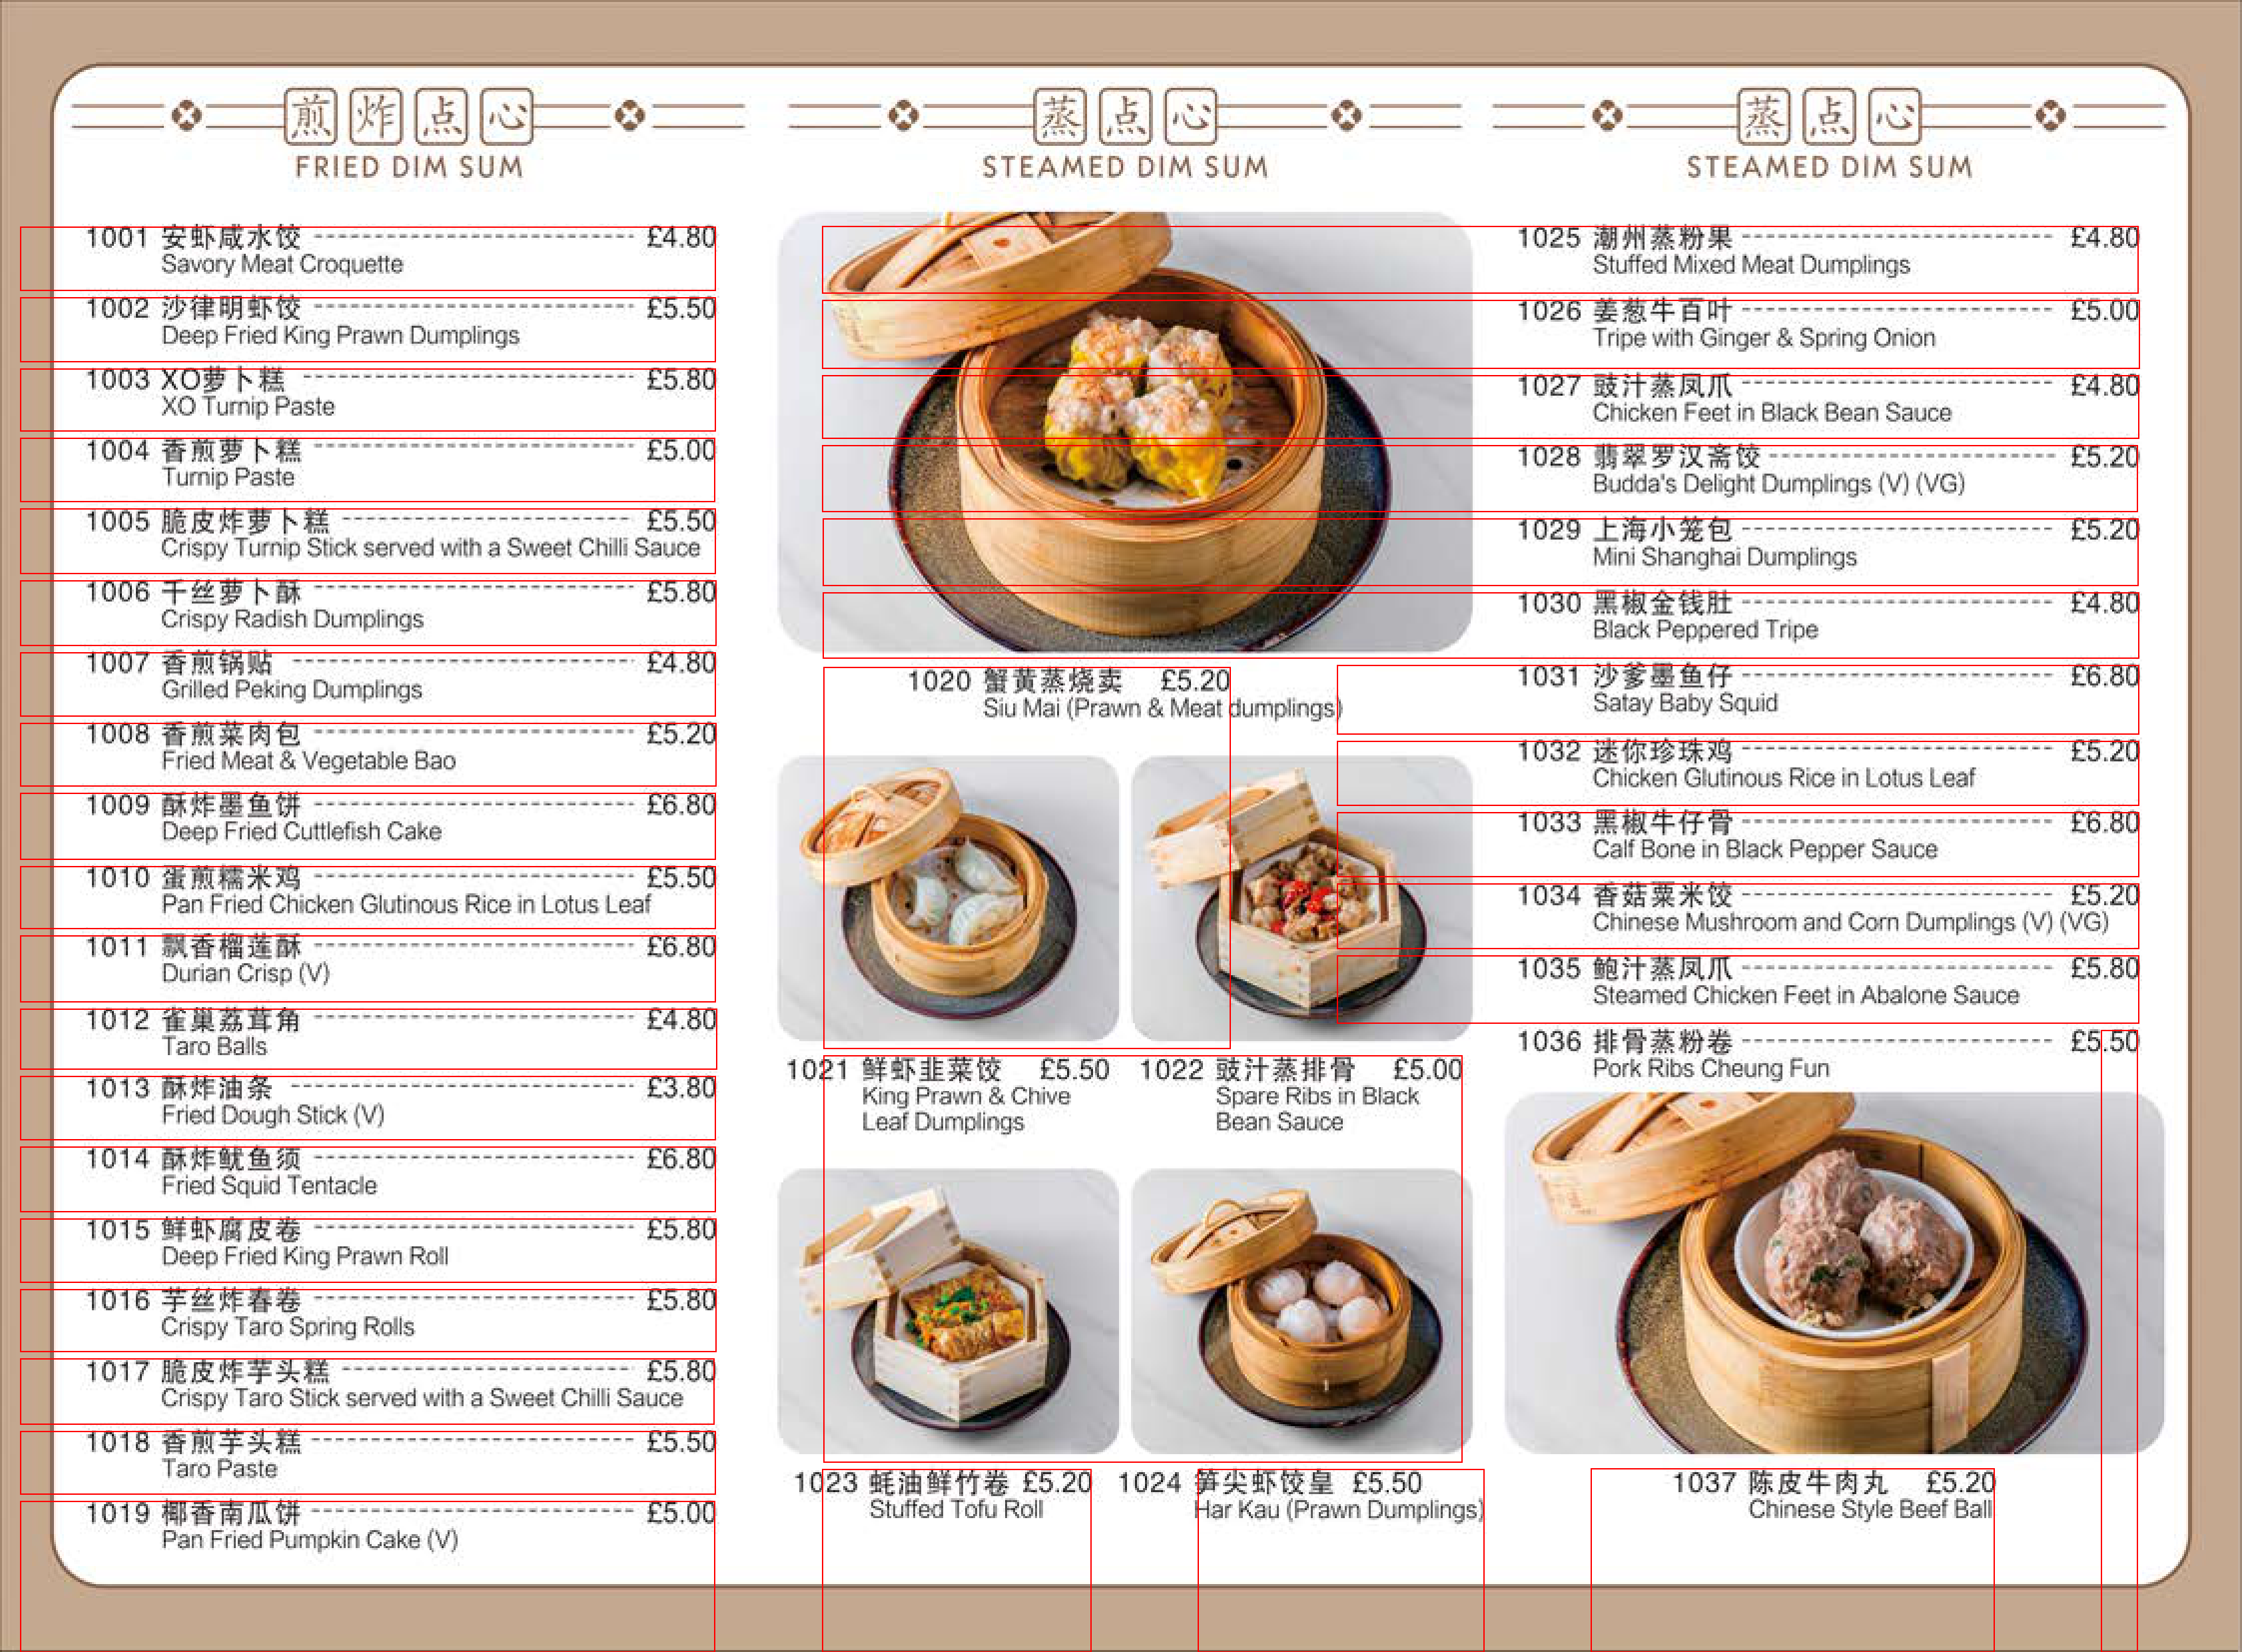

Saving segmented menu...
Chinese Name: ['潮州', '蒸', '粉', '果']
English Name: ['Stuffed', 'Mixed', 'Meat', 'Dumplings']
Chinese Description: []
English Description: []

Chinese Name: ['安', '虾', '咸', '水饺']
English Name: ['Savory', 'Meat', 'Croquette']
Chinese Description: []
English Description: []

Chinese Name: ['沙律', '明虾', '饺']
English Name: ['Deep', 'Fried', 'King', 'Prawn', 'Dumplings']
Chinese Description: []
English Description: []

Chinese Name: ['姜葱', '牛', '百叶']
English Name: ['Tripe', 'with', 'Ginger', 'and', 'Spring', 'Onion']
Chinese Description: []
English Description: []

Chinese Name: ['萝卜', '糕']
English Name: ['XO']
Chinese Description: []
English Description: [['XO', 'Turnip', 'Paste']]

Chinese Name: ['豉', '汁', '蒸', '凤爪']
English Name: ['Chicken', 'Feet', 'in', 'Black', 'Bean', 'Sauce']
Chinese Description: []
English Description: []

Chinese Name: ['香煎', '萝卜', '糕']
English Name: ['Turnip', 'Paste']
Chinese Description: []
English Description: []

Chinese Name: ['翡翠', '罗汉

<Figure size 1000x1000 with 0 Axes>

In [63]:

dir_path = '../downloaded_menu/cleaned_img'
processor = MenuProcessor(dir_path)
processor.saving_progress = True
    
processor.setup_filepath()
processor.process_menu()

processor.save_progress()